## In this notebook: breast cancer diagnosis using support vector machine

In [1]:
import sys

# Matrix operations
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Data handling
import pandas as pd

# Support vector machine model
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# SMOTE sampling
import imblearn
from imblearn.over_sampling import SMOTE

# PCA for visualization purposes
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

### Data visualization

In [2]:
filepath = "breast-cancer-wisconsin-original.csv"
attributes = ['id','diagnosis','radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean',
              'compactness_mean','concavity_mean','concave_points_mean','symmetry_mean','fractal_dimension_mean',
              'radius_se','texture_se','perimeter_se','area_se','smoothness_se','compactness_se','concavity_se',
              'concave points_se','symmetry_se','fractal_dimension_se','radius_worst','texture_worst',
              'perimeter_worst','area_worst','smoothness_worst','compactness_worst','concavity_worst','concave_points_worst',
              'symmetry_worst','fractal_dimension_worst']

df = pd.read_csv(
    filepath_or_buffer = filepath,
    names = attributes)

df.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### There is relatively a small amount of data so we will see how well the models perform

In [3]:
print(df.shape)

(569, 32)


In [4]:
df.drop(
    labels = ['id'],
    axis = 1,
    inplace = True)

df['diagnosis'] = pd.get_dummies(df['diagnosis'])

df.head(3)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


### Slight imbalance of the data so we will oversample by using SMOTE

In [5]:
df.groupby('diagnosis').count()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
diagnosis,,,,,,,,,,,,,,,,,,,,,
0,212,212,212,212,212,212,212,212,212,212,...,212,212,212,212,212,212,212,212,212,212
1,357,357,357,357,357,357,357,357,357,357,...,357,357,357,357,357,357,357,357,357,357


### Because SVM is distance based, we need to normalize the data

In [6]:
y = np.array(df['diagnosis'])
df = np.array(df.drop(['diagnosis'], 1))

scaler = MinMaxScaler(
    copy=True,
    feature_range=(0, 1))

scaler.fit(df)
df = scaler.transform(df)

scaler = StandardScaler()
scaler.fit(df)
df = scaler.transform(df)

In [7]:
df

array([[ 1.09706398, -2.07333501,  1.26993369, ...,  2.29607613,
         2.75062224,  1.93701461],
       [ 1.82982061, -0.35363241,  1.68595471, ...,  1.0870843 ,
        -0.24388967,  0.28118999],
       [ 1.57988811,  0.45618695,  1.56650313, ...,  1.95500035,
         1.152255  ,  0.20139121],
       ...,
       [ 0.70228425,  2.0455738 ,  0.67267578, ...,  0.41406869,
        -1.10454895, -0.31840916],
       [ 1.83834103,  2.33645719,  1.98252415, ...,  2.28998549,
         1.91908301,  2.21963528],
       [-1.80840125,  1.22179204, -1.81438851, ..., -1.74506282,
        -0.04813821, -0.75120669]])

### Oversample with SMOTE

In [8]:
X = np.array(df)

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X,
    y,
    test_size = 0.2)

sm = SMOTE(
    sampling_strategy='not majority',
    k_neighbors = 5,
    n_jobs = 1,
    random_state = 12,
    ratio = 1.0)

X_res, y_res = sm.fit_sample(
    X_train,
    y_train)

In [9]:
print('X_train length: ' + str(len(X_train)))
print('X_test length: ' + str(len(X_test)))
print('X_res length: ' + str(len(X_res)))

X_train length: 455
X_test length: 114
X_res length: 560


## Support Vector Machine 
Use grid search to find the best kernel and value of C

In [10]:
clf = SVC(gamma = 'auto')

parameters = {
    'kernel':('linear', 'rbf'),
    'C':[0.1, 0.5, 1, 2, 5, 10, 100, 1000]}

clf = GridSearchCV(
    clf, parameters,
    cv = 10,
    return_train_score = True,
    iid = False)

clf.fit(
    X_train,
    y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [0.1, 0.5, 1, 2, 5, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [11]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_C',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'split5_test_score',
 'split5_train_score',
 'split6_test_score',
 'split6_train_score',
 'split7_test_score',
 'split7_train_score',
 'split8_test_score',
 'split8_train_score',
 'split9_test_score',
 'split9_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

In [12]:
print(clf.cv_results_)

{'mean_fit_time': array([0.00194945, 0.00392551, 0.00173099, 0.00264781, 0.00194492,
       0.0023653 , 0.00189469, 0.00229361, 0.0025208 , 0.00223877,
       0.00322573, 0.00226636, 0.01809099, 0.00367849, 0.03691006,
       0.00312991]), 'std_fit_time': array([0.00054976, 0.00015312, 0.00028002, 0.00020116, 0.00025559,
       0.00010298, 0.00026112, 0.00021128, 0.00048728, 0.00012995,
       0.00091037, 0.00016136, 0.01622817, 0.00096894, 0.03325061,
       0.00085675]), 'mean_score_time': array([0.00064411, 0.00058179, 0.00031269, 0.00042815, 0.00031209,
       0.0004108 , 0.00025489, 0.00045614, 0.00025516, 0.00035932,
       0.00025411, 0.00035996, 0.00041203, 0.00076513, 0.00075619,
       0.00045443]), 'std_score_time': array([6.18273164e-04, 5.64938143e-05, 1.39248177e-04, 3.19866403e-05,
       8.10058481e-05, 3.13686736e-05, 1.07391361e-05, 1.81426444e-04,
       1.72169912e-05, 1.89077959e-05, 1.64009802e-05, 4.05518815e-05,
       2.42144482e-04, 3.39515102e-04, 3.39297584e

In [13]:
clf.best_estimator_

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [14]:
optimized_svm = clf.best_estimator_

optimized_svm.fit(
    X_train,
    y_train)

cv_results = model_selection.cross_val_score(
    optimized_svm,
    X_train,
    y_train,
    cv = 10,
    scoring='accuracy')

prediction_svm = optimized_svm.predict(X_test)

print('Test accuracy: ' + str(accuracy_score(y_test,prediction_svm)))
print('')
print('')
print(classification_report(
    y_test,
    prediction_svm))

Test accuracy: 0.9824561403508771


              precision    recall  f1-score   support

           0       1.00      0.95      0.97        37
           1       0.97      1.00      0.99        77

   micro avg       0.98      0.98      0.98       114
   macro avg       0.99      0.97      0.98       114
weighted avg       0.98      0.98      0.98       114



### Rerun model with upsampled data to see if accuracy improves

In [15]:
clf = SVC(gamma = 'auto')

parameters = {
    'kernel':('linear', 'rbf'),
    'C':[0.1, 0.5, 1, 2, 5, 10, 100, 1000]}

clf = GridSearchCV(
    clf, parameters,
    cv = 10,
    return_train_score = True,
    iid = False)

clf.fit(
    X_res,
    y_res)

optimized_svm = clf.best_estimator_

optimized_svm.fit(
    X_res,
    y_res)

cv_results = model_selection.cross_val_score(
    optimized_svm,
    X_train,
    y_train,
    cv = 10,
    scoring='accuracy')

clf.best_params_

{'C': 0.1, 'kernel': 'linear'}

In [16]:
prediction_svm = optimized_svm.predict(X_test)

print('Test accuracy: ' + str(accuracy_score(y_test,prediction_svm)))
print('')
print('')
print(classification_report(
    y_test,
    prediction_svm))

Test accuracy: 0.9824561403508771


              precision    recall  f1-score   support

           0       0.97      0.97      0.97        37
           1       0.99      0.99      0.99        77

   micro avg       0.98      0.98      0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



## To visualize the hyperplanes, use PCA to reduce to 2 dimensions

In [17]:
pca = PCA(n_components = 2)

In [18]:
principalComponents = pca.fit_transform(X_train)

In [19]:
optimized_svm.fit(
    principalComponents,
    y_train)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Plot the decision boundary from grid search

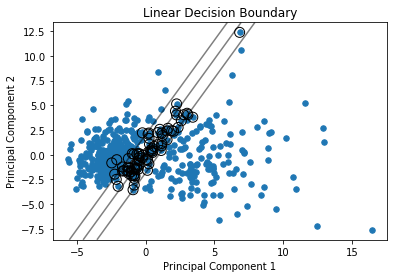

In [20]:
plt.scatter(principalComponents[:, 0],
            principalComponents[:, 1],
            s = 30,
            cmap = plt.cm.Paired)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(
    start = xlim[0],
    stop = xlim[1],
    num = 30)

yy = np.linspace(
    start = ylim[0],
    stop = ylim[1],
    num = 30)

YY, XX = np.meshgrid(
    yy,
    xx)

xy = np.vstack([XX.ravel(), YY.ravel()]).T

Z = clf.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['-', '-', '-'])

ax.scatter(optimized_svm.support_vectors_[:, 0], optimized_svm.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.title('Linear Decision Boundary')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


## Out of curiousity, the radial basis function boundary is plotted below

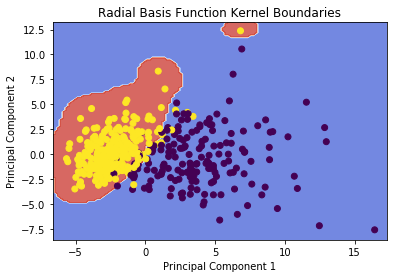

In [21]:
import matplotlib.pyplot as plt

clf = SVC(
    gamma = 'auto',
    C = 1.0,
    kernel = 'rbf')

clf.fit(principalComponents,
        y_train)

h = 0.2
x_min, x_max = principalComponents[:,0].min() - 1, principalComponents[:, 0].max() + 1
y_min, y_max = principalComponents[:,1].min() - 1, principalComponents[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h))

Z = clf.predict(
    np.c_[xx.ravel(),
          yy.ravel()])

Z = Z.reshape(xx.shape)

plt.contourf(
    xx,
    yy,
    Z,
    cmap = plt.cm.coolwarm,
    alpha = 0.8)

plt.scatter(
    principalComponents[:,0],
    principalComponents[:,1],
    c = y_train)

plt.title('Radial Basis Function Kernel Boundaries')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
